In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Pertemuan9').getOrCreate()

In [2]:
# Membuat data karyawan
data = [
    ('James', 34, 'M', 3000, 1),
    ('Anna', 28, 'F', 4100, 2),
    ('Lee', 23, 'M', 2700, 1)
]
columns = ['Name', 'Age', 'Gender', 'Salary', 'DeptId']

# Membuat DataFrame
df = spark.createDataFrame(data, schema=columns)

# Membuat temporary view untuk query SQL
df.createOrReplaceTempView('employees')

In [3]:
spark.sql('SELECT * FROM employees').show()

+-----+---+------+------+------+
| Name|Age|Gender|Salary|DeptId|
+-----+---+------+------+------+
|James| 34|     M|  3000|     1|
| Anna| 28|     F|  4100|     2|
|  Lee| 23|     M|  2700|     1|
+-----+---+------+------+------+



In [4]:
spark.sql('SELECT Name, Age FROM employees WHERE Salary > 3000').show()

+----+---+
|Name|Age|
+----+---+
|Anna| 28|
+----+---+



In [5]:
spark.sql('SELECT AVG(Salary) FROM employees').show()

+------------------+
|       avg(Salary)|
+------------------+
|3266.6666666666665|
+------------------+



In [6]:
spark.sql('''
SELECT Gender, SUM(Salary) as TotalSalary, Age
FROM employees
GROUP BY Gender, Age
ORDER BY Age
''').show()

+------+-----------+---+
|Gender|TotalSalary|Age|
+------+-----------+---+
|     M|       2700| 23|
|     F|       4100| 28|
|     M|       3000| 34|
+------+-----------+---+



In [7]:
spark.sql('''
SELECT DeptId, AVG(Salary) as AvgSalary
FROM employees
GROUP BY DeptId
ORDER BY DeptId
''').show()

+------+---------+
|DeptId|AvgSalary|
+------+---------+
|     1|   2850.0|
|     2|   4100.0|
+------+---------+



In [9]:
spark.sql('''
SELECT e.Name, e.Gender, e.Salary
FROM employees e
WHERE e.Salary > (
    SELECT AVG(Salary)
    FROM employees
    WHERE Gender = e.Gender
)
''').show()

+-----+------+------+
| Name|Gender|Salary|
+-----+------+------+
|James|     M|  3000|
+-----+------+------+



In [10]:
spark.sql('''
SELECT Name, DeptId, Salary,
       RANK() OVER (PARTITION BY DeptId ORDER BY Salary DESC) as Rank
FROM employees
''').show()

+-----+------+------+----+
| Name|DeptId|Salary|Rank|
+-----+------+------+----+
|James|     1|  3000|   1|
|  Lee|     1|  2700|   2|
| Anna|     2|  4100|   1|
+-----+------+------+----+



In [12]:
spark.sql('''
SELECT Name, Age, Salary,
       ROW_NUMBER() OVER (PARTITION BY Age ORDER BY Salary DESC) as rank
FROM employees
''').show()

+-----+---+------+----+
| Name|Age|Salary|rank|
+-----+---+------+----+
|  Lee| 23|  2700|   1|
| Anna| 28|  4100|   1|
|James| 34|  3000|   1|
+-----+---+------+----+



In [13]:
# Data karyawan
employees = spark.createDataFrame([
    ('James', 34, 'M', 3000, 1),
    ('Anna', 28, 'F', 4100, 2),
    ('Lee', 23, 'M', 2700, 1)
], ['Name', 'Age', 'Gender', 'Salary', 'DeptId'])

# Data departemen
departments = spark.createDataFrame([
    (1, 'HR'),
    (2, 'Marketing')
], ['DeptId', 'DeptName'])

# Data proyek
projects = spark.createDataFrame([
    (1, 'Project A'),
    (2, 'Project B')
], ['DeptId', 'ProjectName'])

# Membuat temporary views
employees.createOrReplaceTempView('employees')
departments.createOrReplaceTempView('departments')
projects.createOrReplaceTempView('projects')

In [14]:
spark.sql('''
SELECT e.Name, e.Age, d.DeptName, p.ProjectName
FROM employees e
JOIN departments d ON e.DeptId = d.DeptId
JOIN projects p ON e.DeptId = p.DeptId
''').show()

+-----+---+---------+-----------+
| Name|Age| DeptName|ProjectName|
+-----+---+---------+-----------+
|  Lee| 23|       HR|  Project A|
|James| 34|       HR|  Project A|
| Anna| 28|Marketing|  Project B|
+-----+---+---------+-----------+



In [15]:
spark.sql('''
SELECT e.Name, e.Salary, d.DeptName,
       AVG(e.Salary) OVER (PARTITION BY e.DeptId) as AvgDeptSalary,
       RANK() OVER (PARTITION BY e.DeptId ORDER BY e.Salary DESC) as Rank
FROM employees e
JOIN departments d ON e.DeptId = d.DeptId
''').show()

+-----+------+---------+-------------+----+
| Name|Salary| DeptName|AvgDeptSalary|Rank|
+-----+------+---------+-------------+----+
|James|  3000|       HR|       2850.0|   1|
|  Lee|  2700|       HR|       2850.0|   2|
| Anna|  4100|Marketing|       4100.0|   1|
+-----+------+---------+-------------+----+



In [16]:
spark.sql('''
SELECT e.Age, d.DeptName, AVG(e.Salary) as AvgSalary
FROM employees e
JOIN departments d ON e.DeptId = d.DeptId
GROUP BY e.Age, d.DeptName
ORDER BY e.Age
''').show()

+---+---------+---------+
|Age| DeptName|AvgSalary|
+---+---------+---------+
| 23|       HR|   2700.0|
| 28|Marketing|   4100.0|
| 34|       HR|   3000.0|
+---+---------+---------+



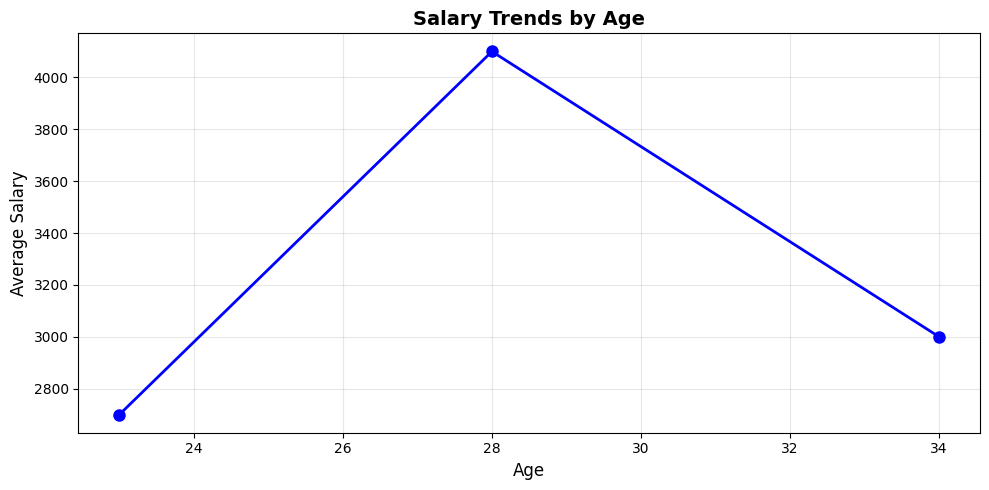

In [17]:
import matplotlib.pyplot as plt
import pandas as pd

# Query untuk analisis tren gaji
salary_trends = spark.sql('''
SELECT Age, AVG(Salary) AS AverageSalary
FROM employees
GROUP BY Age
ORDER BY Age
''').toPandas()

# Membuat visualisasi
plt.figure(figsize=(10, 5))
plt.plot(salary_trends['Age'], salary_trends['AverageSalary'],
         marker='o', linewidth=2, markersize=8, color='blue')
plt.xlabel('Age', fontsize=12)
plt.ylabel('Average Salary', fontsize=12)
plt.title('Salary Trends by Age', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

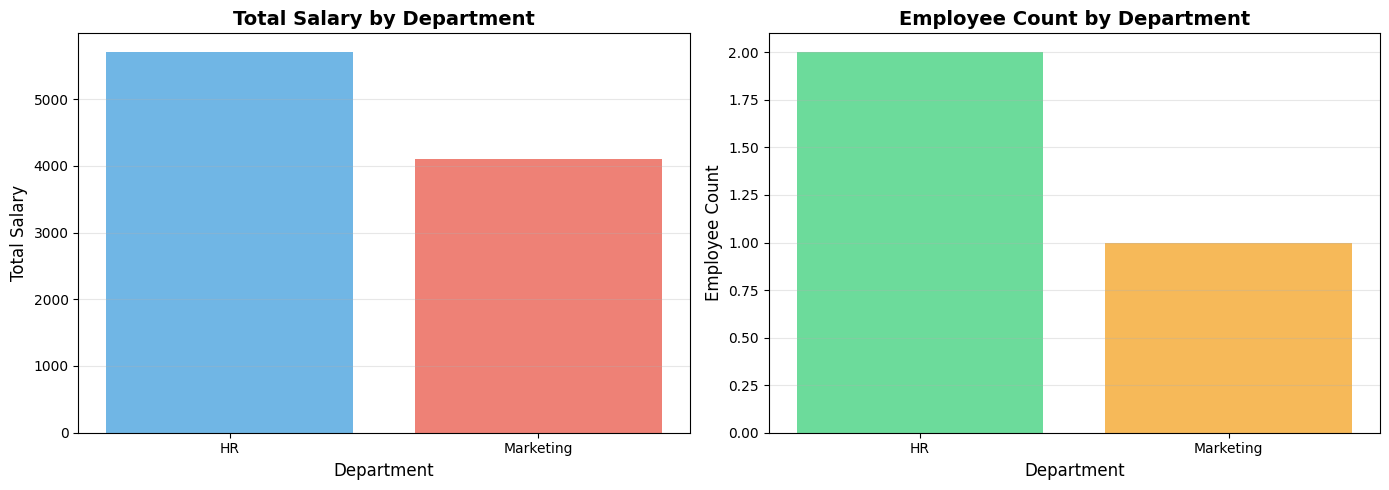

In [18]:
# Query untuk total gaji dan jumlah karyawan
dept_stats = spark.sql('''
SELECT d.DeptName,
       SUM(e.Salary) as TotalSalary,
       COUNT(e.Name) as EmployeeCount
FROM employees e
JOIN departments d ON e.DeptId = d.DeptId
GROUP BY d.DeptName
''').toPandas()

# Visualisasi dengan bar chart
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Chart 1: Total Gaji
ax1.bar(dept_stats['DeptName'], dept_stats['TotalSalary'],
        color=['#3498db', '#e74c3c'], alpha=0.7)
ax1.set_xlabel('Department', fontsize=12)
ax1.set_ylabel('Total Salary', fontsize=12)
ax1.set_title('Total Salary by Department', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Chart 2: Jumlah Karyawan
ax2.bar(dept_stats['DeptName'], dept_stats['EmployeeCount'],
        color=['#2ecc71', '#f39c12'], alpha=0.7)
ax2.set_xlabel('Department', fontsize=12)
ax2.set_ylabel('Employee Count', fontsize=12)
ax2.set_title('Employee Count by Department', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

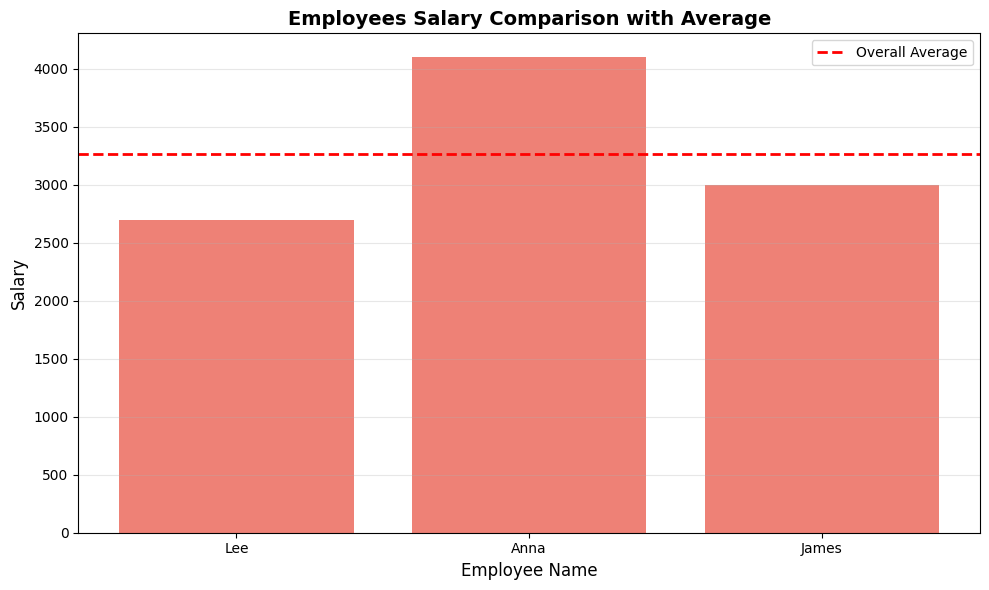

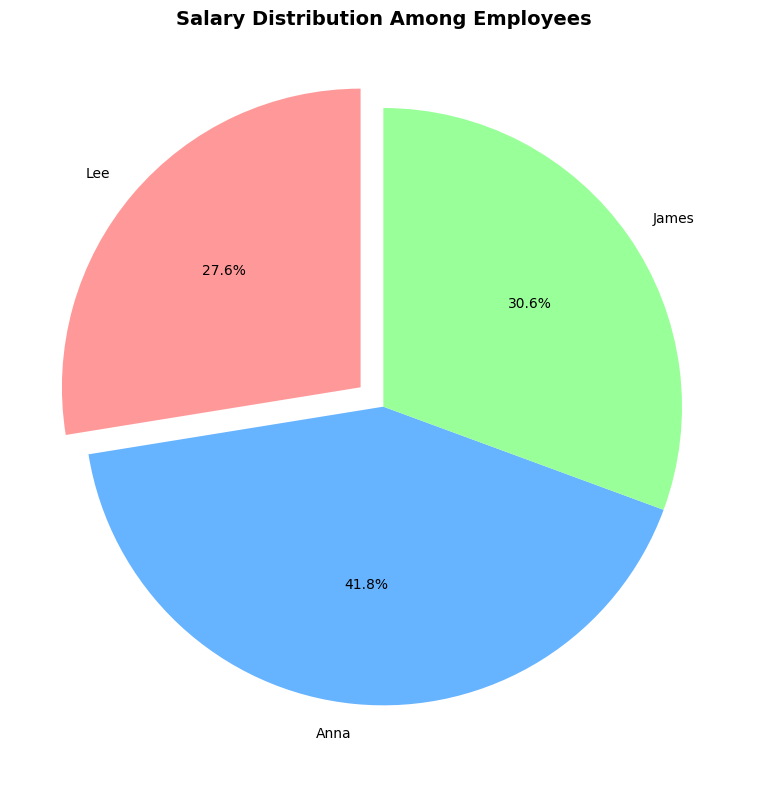

In [19]:
# Query untuk menemukan karyawan dengan gaji di atas rata-rata
above_avg = spark.sql('''
SELECT e.Name, e.Age, e.Salary,
       AVG(e.Salary) OVER (PARTITION BY e.Age) as AvgAgeSalary,
       e.Salary - AVG(e.Salary) OVER (PARTITION BY e.Age) as Difference
FROM employees e
''').toPandas()

above_avg_filtered = above_avg[above_avg['Difference'] > 0]

# Visualisasi dengan bar chart
plt.figure(figsize=(10, 6))
colors = ['#27ae60' if x > 0 else '#e74c3c'
          for x in above_avg['Difference']]
plt.bar(above_avg['Name'], above_avg['Salary'], color=colors, alpha=0.7)
plt.axhline(y=above_avg['Salary'].mean(), color='r',
            linestyle='--', label='Overall Average', linewidth=2)
plt.xlabel('Employee Name', fontsize=12)
plt.ylabel('Salary', fontsize=12)
plt.title('Employees Salary Comparison with Average',
          fontsize=14, fontweight='bold')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Pie chart untuk perbandingan
fig, ax = plt.subplots(figsize=(8, 8))
sizes = above_avg['Salary']
colors_pie = ['#ff9999', '#66b3ff', '#99ff99']
explode = (0.1, 0, 0)
ax.pie(sizes, explode=explode, labels=above_avg['Name'],
       colors=colors_pie, autopct='%1.1f%%', startangle=90)
ax.set_title('Salary Distribution Among Employees',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [20]:
import random
from datetime import datetime, timedelta

# Generate data karyawan yang lebih besar
random.seed(42)
large_data = []
names = ['John', 'Emma', 'Michael', 'Sophia', 'William', 'Olivia',
         'James', 'Ava', 'Robert', 'Isabella', 'David', 'Mia',
         'Richard', 'Charlotte', 'Joseph', 'Amelia', 'Thomas', 'Harper']
genders = ['M', 'F']
departments = [1, 2, 3, 4, 5]

for i in range(150):
    name = random.choice(names) + str(i)
    age = random.randint(22, 60)
    gender = random.choice(genders)
    salary = random.randint(2500, 8000)
    dept_id = random.choice(departments)
    years_exp = random.randint(0, age - 22)
    large_data.append((name, age, gender, salary, dept_id, years_exp))

# Membuat DataFrame
large_df = spark.createDataFrame(large_data,
    ['Name', 'Age', 'Gender', 'Salary', 'DeptId', 'YearsExperience'])

# Membuat department data
dept_data = [
    (1, 'Human Resources', 'HR'),
    (2, 'Marketing', 'MKT'),
    (3, 'Engineering', 'ENG'),
    (4, 'Finance', 'FIN'),
    (5, 'Operations', 'OPS')
]
large_dept_df = spark.createDataFrame(dept_data,
    ['DeptId', 'DeptName', 'DeptCode'])

# Create temp views
large_df.createOrReplaceTempView('large_employees')
large_dept_df.createOrReplaceTempView('large_departments')

In [21]:
# Analisis 1: Statistik Gaji Per Departemen
dept_salary_stats = spark.sql('''
SELECT d.DeptName,
       COUNT(e.Name) as EmployeeCount,
       SUM(e.Salary) as TotalSalary,
       AVG(e.Salary) as AvgSalary,
       MIN(e.Salary) as MinSalary,
       MAX(e.Salary) as MaxSalary,
       STDDEV(e.Salary) as StdDevSalary
FROM large_employees e
JOIN large_departments d ON e.DeptId = d.DeptId
GROUP BY d.DeptName
ORDER BY AvgSalary DESC
''').toPandas()

print(dept_salary_stats)

          DeptName  EmployeeCount  TotalSalary    AvgSalary  MinSalary  \
0          Finance             35       190732  5449.485714       2521   
1       Operations             28       151178  5399.214286       2666   
2  Human Resources             31       164013  5290.741935       2558   
3      Engineering             31       155025  5000.806452       2757   
4        Marketing             25       120705  4828.200000       2553   

   MaxSalary  StdDevSalary  
0       7980   1610.546662  
1       7823   1733.521023  
2       7984   1867.831380  
3       7919   1443.403026  
4       7917   1598.216245  


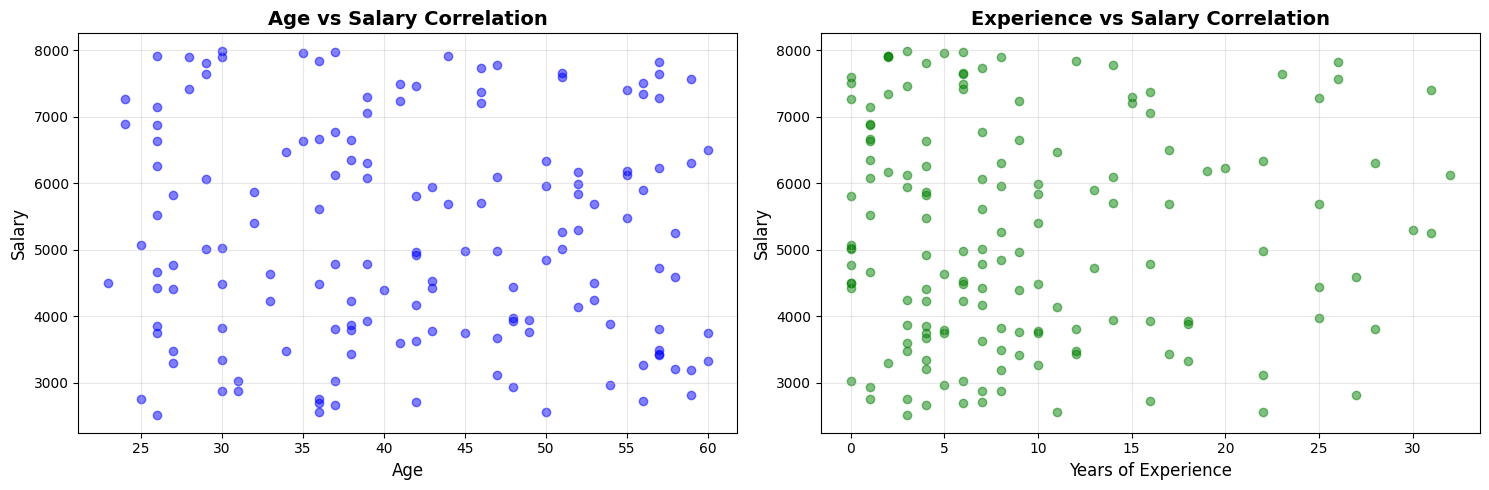

In [22]:
# Query untuk korelasi
correlation_data = spark.sql('''
SELECT Age, YearsExperience, Salary,
       AVG(Salary) OVER (PARTITION BY Age) as AvgSalaryByAge,
       AVG(Salary) OVER (PARTITION BY YearsExperience) as AvgSalaryByExp
FROM large_employees
''').toPandas()

# Visualisasi scatter plot
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Age vs Salary
axes[0].scatter(correlation_data['Age'], correlation_data['Salary'],
                alpha=0.5, c='blue')
axes[0].set_xlabel('Age', fontsize=12)
axes[0].set_ylabel('Salary', fontsize=12)
axes[0].set_title('Age vs Salary Correlation', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Plot 2: Experience vs Salary
axes[1].scatter(correlation_data['YearsExperience'],
                correlation_data['Salary'], alpha=0.5, c='green')
axes[1].set_xlabel('Years of Experience', fontsize=12)
axes[1].set_ylabel('Salary', fontsize=12)
axes[1].set_title('Experience vs Salary Correlation',
                  fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

/tmp/ipython-input-2768214585.py:54: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax5.boxplot(dept_salary_box, labels=dept_labels)


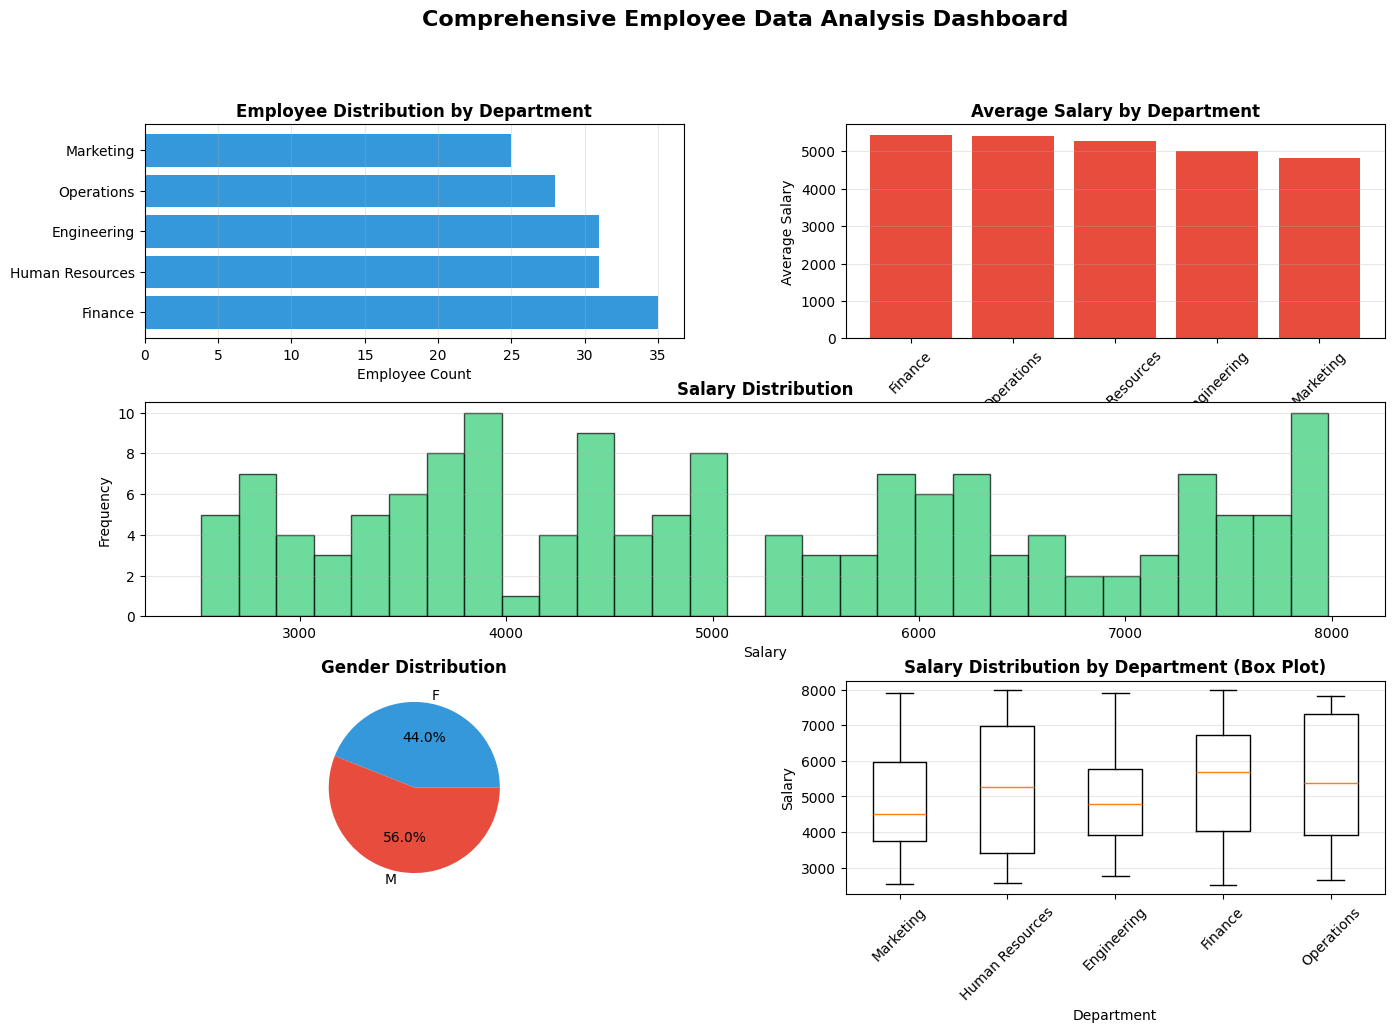

In [23]:
# Membuat dashboard dengan multiple charts
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# Chart 1: Distribusi Karyawan Per Departemen
ax1 = fig.add_subplot(gs[0, 0])
dept_count = dept_salary_stats.sort_values('EmployeeCount', ascending=False)
ax1.barh(dept_count['DeptName'], dept_count['EmployeeCount'],
         color='#3498db')
ax1.set_xlabel('Employee Count')
ax1.set_title('Employee Distribution by Department', fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# Chart 2: Rata-rata Gaji Per Departemen
ax2 = fig.add_subplot(gs[0, 1])
ax2.bar(dept_salary_stats['DeptName'], dept_salary_stats['AvgSalary'],
        color='#e74c3c')
ax2.set_xlabel('Department')
ax2.set_ylabel('Average Salary')
ax2.set_title('Average Salary by Department', fontweight='bold')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(axis='y', alpha=0.3)

# Chart 3: Distribusi Gaji (Histogram)
ax3 = fig.add_subplot(gs[1, :])
ax3.hist(correlation_data['Salary'], bins=30, color='#2ecc71',
         alpha=0.7, edgecolor='black')
ax3.set_xlabel('Salary')
ax3.set_ylabel('Frequency')
ax3.set_title('Salary Distribution', fontweight='bold')
ax3.grid(axis='y', alpha=0.3)

# Chart 4: Pie Chart Gender Distribution
ax4 = fig.add_subplot(gs[2, 0])
gender_dist = large_df.groupBy('Gender').count().toPandas()
ax4.pie(gender_dist['count'], labels=gender_dist['Gender'],
        autopct='%1.1f%%', colors=['#3498db', '#e74c3c'])
ax4.set_title('Gender Distribution', fontweight='bold')

# Chart 5: Box Plot Gaji Per Departemen
ax5 = fig.add_subplot(gs[2, 1])
dept_salary_box = []
dept_labels = []
for dept in large_dept_df.select('DeptName').distinct().collect():
    dept_name = dept['DeptName']
    salaries = large_df.filter(
        large_df.DeptId == large_dept_df.filter(
            large_dept_df.DeptName == dept_name
        ).select('DeptId').first()[0]
    ).select('Salary').toPandas()['Salary'].tolist()
    dept_salary_box.append(salaries)
    dept_labels.append(dept_name)

ax5.boxplot(dept_salary_box, labels=dept_labels)
ax5.set_xlabel('Department')
ax5.set_ylabel('Salary')
ax5.set_title('Salary Distribution by Department (Box Plot)',
              fontweight='bold')
ax5.tick_params(axis='x', rotation=45)
ax5.grid(axis='y', alpha=0.3)

plt.suptitle('Comprehensive Employee Data Analysis Dashboard',
             fontsize=16, fontweight='bold', y=0.995)
plt.show()